In [13]:
import pandas as pd

df = pd.read_csv("dataR2.csv")

display(df.head())

print("\nDataset Summary:")
print(df.describe())

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1



Dataset Summary:
              Age         BMI     Glucose     Insulin        HOMA      Leptin  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    57.301724   27.582111   97.793103   10.012086    2.694988   26.615080   
std     16.112766    5.020136   22.525162   10.067768    3.642043   19.183294   
min     24.000000   18.370000   60.000000    2.432000    0.467409    4.311000   
25%     45.000000   22.973205   85.750000    4.359250    0.917966   12.313675   
50%     56.000000   27.662416   92.000000    5.924500    1.380939   20.271000   
75%     71.000000   31.241442  102.000000   11.189250    2.857787   37.378300   
max     89.000000   38.578759  201.000000   58.460000   25.050342   90.280000   

       Adiponectin    Resistin        MCP.1  Classification  
count   116.000000  116.000000   116.000000      116.000000  
mean     10.180874   14.725966   534.647000        1.551724  
std       6.843341   12.390646   345.912663        0.499475  
min 

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE   
from sklearn.model_selection import GridSearchCV

***NAIVE APPROACH WITH SOME PARAMETERS***


In [15]:
# Define features and target variable
X = df.drop(columns=['Classification'])  # Assuming 'Classification' is the target column
y = df['Classification']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)
}

# Perform 10-fold cross-validation and collect results
results = []
for name, model in models.items():
    accuracy = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='accuracy'))
    precision = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='precision_weighted'))
    recall = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='recall_weighted'))
    f1 = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='f1_weighted'))
    results.append([name, accuracy, precision, recall, f1])

# Baseline classifier (predicts majority class always)
majority_class = y.mode()[0]
baseline_preds = np.full(y.shape, majority_class)
baseline_acc = accuracy_score(y, baseline_preds)
baseline_prec = precision_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_recall = recall_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_f1 = f1_score(y, baseline_preds, average='weighted', zero_division=0)
results.insert(0, ["Baseline Classifier", baseline_acc, baseline_prec, baseline_recall, baseline_f1])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Algorithm", "C.C.I.%", "Precision", "Recall", "F-measure"])

# Display the table
print(results_df)


c:\Users\Pol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


             Algorithm   C.C.I.%  Precision    Recall  F-measure
0  Baseline Classifier  0.551724   0.304400  0.551724   0.392337
1  Logistic Regression  0.687879   0.721989  0.687879   0.665287
2        Decision Tree  0.688636   0.724716  0.670455   0.653052
3           k-NN (k=5)  0.650000   0.639278  0.650000   0.629348
4       Neural Network  0.704545   0.696048  0.694697   0.678348


***LOGISTIC REGRESSION***


In [16]:
# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200],  # Expanded range
    'solver': ['liblinear', 'newton-cg'],  # Additional solvers
    'max_iter': [5000, 10000, 20000, 50000]  # Increased iterations
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collect all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_C', 'param_solver', 'param_max_iter', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["C", "Solver", "Max Iterations", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Find and print the best parameters
best_params_logreg = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_logreg)

Best Parameters based on Precision:
C                      10.0
Solver            liblinear
Max Iterations         5000
C.C.I.%            0.696212
Precision          0.724716
Recall             0.696212
F-measure          0.678207
Name: 32, dtype: object


***DECISION TREE***

In [17]:
# Hyperparameter tuning for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],  # Different split criteria
    'max_depth': [10, 20, 30, 50],  # Varying tree depths
    'min_samples_split': [2, 5, 10],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 5]  # Minimum samples needed at a leaf node
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collect all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["Criterion", "Max Depth", "Min Samples Split", "Min Samples Leaf", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Find and print the best parameters
best_params_dt = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_dt)

Best Parameters based on Precision:
Criterion             entropy
Max Depth                  20
Min Samples Split           2
Min Samples Leaf            5
C.C.I.%              0.759848
Precision            0.809842
Recall               0.759848
F-measure            0.750836
Name: 51, dtype: object


***KNN***


In [18]:
# Hyperparameter tuning for k-NN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Different values of k
    'weights': ['uniform', 'distance'],  # Weighting methods
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collect all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["k Neighbors", "Weights", "Metric", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Find and print the best parameters
best_params_knn = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_knn)


Best Parameters based on Precision:
k Neighbors           15
Weights         distance
Metric         manhattan
C.C.I.%         0.720455
Precision       0.751593
Recall          0.720455
F-measure       0.706988
Name: 23, dtype: object


***ARTIFICIAL NEURAL NETWORKS***

In [19]:
# Hyperparameter tuning for Neural Networks (MLP)
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10,10), (20,10)],  
    'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'solver': ['adam', 'sgd'],
    'max_iter': [2000, 5000, 10000] # Maximum iterations 
}

mlp = MLPClassifier()
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collect all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_hidden_layer_sizes', 'param_activation', 'param_solver', 'param_max_iter', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["Hidden Layers", "Activation", "Solver", "Max Iterations", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Find and print the best parameters
best_params_mlp = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_mlp)

Best Parameters based on Precision:
Hidden Layers        (20,)
Activation            relu
Solver                 sgd
Max Iterations        5000
C.C.I.%           0.729545
Precision         0.758575
Recall            0.729545
F-measure         0.718786
Name: 9, dtype: object


***RESULTS***

In [20]:
# Baseline Classifier (Majority Class Predictor)
majority_class = y.mode()[0]
baseline_preds = np.full(y.shape, majority_class)
baseline_acc = accuracy_score(y, baseline_preds)
baseline_prec = precision_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_recall = recall_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_f1 = f1_score(y, baseline_preds, average='weighted', zero_division=0)

# Collect best results from each model
results = [
    ["Baseline Classifier", baseline_acc, baseline_prec, baseline_recall, baseline_f1],
    ["Logistic Regression", best_params_logreg["C.C.I.%"], best_params_logreg["Precision"], best_params_logreg["Recall"], best_params_logreg["F-measure"]],
    ["Decision Tree", best_params_dt["C.C.I.%"], best_params_dt["Precision"], best_params_dt["Recall"], best_params_dt["F-measure"]],
    ["k-NN", best_params_knn["C.C.I.%"], best_params_knn["Precision"], best_params_knn["Recall"], best_params_knn["F-measure"]],
    ["Neural Network", best_params_mlp["C.C.I.%"], best_params_mlp["Precision"], best_params_mlp["Recall"], best_params_mlp["F-measure"]]
]

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Algorithm", "C.C.I.%", "Precision", "Recall", "F-measure"])

# Display the table
print(results_df)

             Algorithm   C.C.I.%  Precision    Recall  F-measure
0  Baseline Classifier  0.551724   0.304400  0.551724   0.392337
1  Logistic Regression  0.696212   0.724716  0.696212   0.678207
2        Decision Tree  0.759848   0.809842  0.759848   0.750836
3                 k-NN  0.720455   0.751593  0.720455   0.706988
4       Neural Network  0.729545   0.758575  0.729545   0.718786


***OVERFITTING***

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("dataR2.csv")  # Ensure this file is in your working directory

# Define features and target variable
X = df.drop(columns=['Classification'])  # Assuming 'Classification' is the target column
y = df['Classification']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models with best parameters
models = {
    "Logistic Regression": LogisticRegression(C=10.0, solver='liblinear', max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=5),
    "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan'),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=5000)
}

# Train models and compare train/test performance
overfitting_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    overfitting_results.append([name, train_acc, test_acc])

# Convert to DataFrame and display results
overfitting_df = pd.DataFrame(overfitting_results, columns=["Algorithm", "Train Accuracy", "Test Accuracy"])

# Print results
print("Overfitting Analysis:")
print(overfitting_df)


Overfitting Analysis:
             Algorithm  Train Accuracy  Test Accuracy
0  Logistic Regression        0.760870       0.875000
1        Decision Tree        0.869565       0.916667
2          k-NN (k=15)        1.000000       0.875000
3       Neural Network        0.967391       0.875000


***FEATURE SELECTION***


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("dataR2.csv")  # Ensure this file is in your working directory

# Define features and target variable
X = df.drop(columns=['Classification'])
y = df['Classification']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Filter Methods (ANOVA F-score and Mutual Information)
anova_selector = SelectKBest(score_func=f_classif, k=9)
anova_selector.fit(X_scaled, y)
anova_scores = anova_selector.scores_

mutual_info_selector = SelectKBest(score_func=mutual_info_classif, k=9)
mutual_info_selector.fit(X_scaled, y)
mutual_info_scores = mutual_info_selector.scores_

# Apply Wrapper Method (Recursive Feature Elimination - RFE)
rfe_selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=9)
rfe_selector.fit(X_scaled, y)
rfe_ranking = rfe_selector.ranking_

# Combine and Rank Features
feature_names = X.columns
feature_ranking = pd.DataFrame({
    "Feature": feature_names,
    "ANOVA Score": anova_scores,
    "Mutual Info Score": mutual_info_scores,
    "RFE Ranking": rfe_ranking
}).sort_values(by="ANOVA Score", ascending=False)

# Display Feature Selection Results
print("Feature Selection Rankings:")
print(feature_ranking)


Feature Selection Rankings:
       Feature  ANOVA Score  Mutual Info Score  RFE Ranking
2      Glucose    19.755454           0.109569            1
4         HOMA    10.002398           0.016421            1
3      Insulin     9.459504           0.000000            1
7     Resistin     6.211315           0.057669            1
1          BMI     2.039862           0.000000            1
8        MCP.1     0.959962           0.000000            1
0          Age     0.216670           0.137938            1
6  Adiponectin     0.043322           0.000000            1
5       Leptin     0.000133           0.000000            1
Top 5 Most Important Features Based on ANOVA Score:
    Feature  ANOVA Score
2   Glucose    19.755454
4      HOMA    10.002398
3   Insulin     9.459504
7  Resistin     6.211315
1       BMI     2.039862


In [33]:
# Print the top 5 most important features as a text sentence
top_5_features = feature_ranking.head(5)[["Feature", "ANOVA Score"]]

# Convert to a readable string format
features_text = ", ".join([f"{row['Feature']} (Score: {row['ANOVA Score']:.4f})" for _, row in top_5_features.iterrows()])

# Print result
print(f"Top 5 Most Important Features Based on ANOVA Score: {features_text}")


Top 5 Most Important Features Based on ANOVA Score: Glucose (Score: 19.7555), HOMA (Score: 10.0024), Insulin (Score: 9.4595), Resistin (Score: 6.2113), BMI (Score: 2.0399)


In [34]:
from itertools import combinations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Generate different feature combinations (3 to 5 features)
feature_combinations = []
for n in range(3, 6):  # Selecting combinations of 3, 4, or 5 features
    feature_combinations.extend(list(combinations(top_5_features["Feature"], n)))

# Dictionary to store results
feature_selection_results = []

# Load dataset
df = pd.read_csv("dataR2.csv")  # Ensure this file is in your working directory

# Define target variable
y = df['Classification']

# Standardize the dataset
scaler = StandardScaler()

# Loop through different feature sets
for selected_features in feature_combinations:
    X_selected = df[list(selected_features)]

    # Standardize Selected Features
    X_selected_scaled = scaler.fit_transform(X_selected)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

    # Train models with selected features
    models = {
        "Logistic Regression": LogisticRegression(C=10.0, solver='liblinear', max_iter=5000),
        "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=5),
        "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan'),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=5000)
    }

    # Evaluate models
    for name, model in models.items():
        model.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, model.predict(X_test))
        feature_selection_results.append([name, selected_features, test_acc])

# Convert results to DataFrame
feature_selection_df = pd.DataFrame(feature_selection_results, columns=["Model", "Selected Features", "Test Accuracy"])

# Display results
print("Feature Selection Model Performance:")
print(feature_selection_df)


Feature Selection Model Performance:
                  Model                        Selected Features  \
0   Logistic Regression                 (Glucose, HOMA, Insulin)   
1         Decision Tree                 (Glucose, HOMA, Insulin)   
2           k-NN (k=15)                 (Glucose, HOMA, Insulin)   
3        Neural Network                 (Glucose, HOMA, Insulin)   
4   Logistic Regression                (Glucose, HOMA, Resistin)   
..                  ...                                      ...   
59       Neural Network           (HOMA, Insulin, Resistin, BMI)   
60  Logistic Regression  (Glucose, HOMA, Insulin, Resistin, BMI)   
61        Decision Tree  (Glucose, HOMA, Insulin, Resistin, BMI)   
62          k-NN (k=15)  (Glucose, HOMA, Insulin, Resistin, BMI)   
63       Neural Network  (Glucose, HOMA, Insulin, Resistin, BMI)   

    Test Accuracy  
0        0.708333  
1        0.625000  
2        0.750000  
3        0.750000  
4        0.791667  
..            ...  
59    

In [37]:
# Identify and print the best feature combinations for each model
best_cases = feature_selection_df.loc[feature_selection_df.groupby("Model")["Test Accuracy"].idxmax()]

print("\nBest Feature Combinations for Each Model:")
for _, row in best_cases.iterrows():
    print(f"{row['Model']}: Features {row['Selected Features']} → Test Accuracy: {row['Test Accuracy']:.4f}")

# Identify and print the top 5 best accuracies overall
top_5_cases = feature_selection_df.nlargest(5, "Test Accuracy")

print("\nTop 5 Best Accuracies Across All Models:")
for _, row in top_5_cases.iterrows():
    print(f"{row['Model']}: Features {row['Selected Features']} → Test Accuracy: {row['Test Accuracy']:.4f}")



Best Feature Combinations for Each Model:
Decision Tree: Features ('Glucose', 'Resistin', 'BMI') → Test Accuracy: 0.8750
Logistic Regression: Features ('Glucose', 'Resistin', 'BMI') → Test Accuracy: 0.8750
Neural Network: Features ('Glucose', 'HOMA', 'Resistin', 'BMI') → Test Accuracy: 0.9167
k-NN (k=15): Features ('Glucose', 'Resistin', 'BMI') → Test Accuracy: 0.9167

Top 5 Best Accuracies Across All Models:
k-NN (k=15): Features ('Glucose', 'Resistin', 'BMI') → Test Accuracy: 0.9167
k-NN (k=15): Features ('Glucose', 'HOMA', 'Resistin', 'BMI') → Test Accuracy: 0.9167
Neural Network: Features ('Glucose', 'HOMA', 'Resistin', 'BMI') → Test Accuracy: 0.9167
Neural Network: Features ('Glucose', 'Insulin', 'Resistin') → Test Accuracy: 0.8750
Logistic Regression: Features ('Glucose', 'Resistin', 'BMI') → Test Accuracy: 0.8750


***LEARNING CURVE***

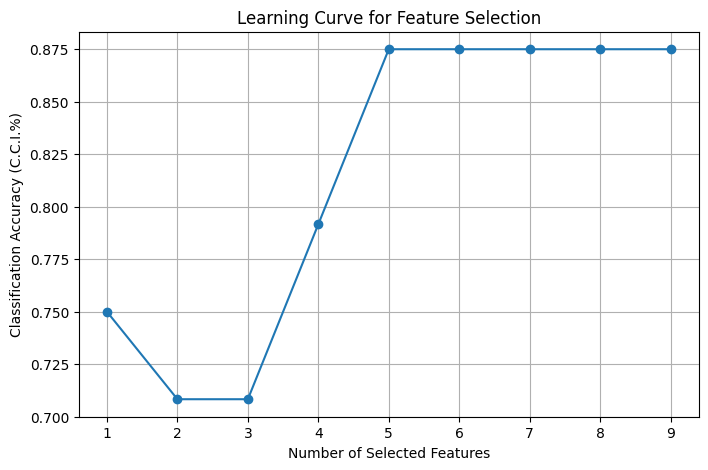

In [30]:
# Learning Curve: Evaluate Performance with Increasing Features
learning_curve_results = []

for num_features in range(1, 10):  # 1 to 9 features
    selected_features = feature_ranking["Feature"][:num_features]
    X_selected = df[selected_features]
    
    # Standardize Selected Features
    X_selected_scaled = scaler.fit_transform(X_selected)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)
    
    # Train Logistic Regression Model
    model = LogisticRegression(C=10.0, solver='liblinear', max_iter=5000)
    model.fit(X_train, y_train)
    
    # Compute Accuracy
    test_acc = accuracy_score(y_test, model.predict(X_test))
    learning_curve_results.append((num_features, test_acc))

# Convert to DataFrame for Plotting
learning_curve_df = pd.DataFrame(learning_curve_results, columns=["Num Features", "Test Accuracy"])

# Plot Learning Curve
plt.figure(figsize=(8,5))
plt.plot(learning_curve_df["Num Features"], learning_curve_df["Test Accuracy"], marker='o', linestyle='-')
plt.xlabel("Number of Selected Features")
plt.ylabel("Classification Accuracy (C.C.I.%)")
plt.title("Learning Curve for Feature Selection")
plt.grid(True)
plt.show()
